In [1]:
# ✅ Instalar dependencias (si estás en Colab)
!pip install -q tensorflow scikit-learn

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
import random

# ====================================
# 1️⃣ Simulación de dataset artificial
# ====================================
np.random.seed(42)
random.seed(42)

NUM_USERS = 1000
NUM_PRODUCTS = 500
NUM_INTERACTIONS = 10000

# Generar pares usuario-producto positivos
user_ids = np.random.randint(0, NUM_USERS, size=NUM_INTERACTIONS)
product_ids = np.random.randint(0, NUM_PRODUCTS, size=NUM_INTERACTIONS)
positives = pd.DataFrame({'user_id': user_ids, 'product_id': product_ids, 'label': 1})

# Generar interacciones negativas por muestreo aleatorio
negatives = []
positive_set = set(zip(user_ids, product_ids))
while len(negatives) < NUM_INTERACTIONS:
    u = np.random.randint(0, NUM_USERS)
    p = np.random.randint(0, NUM_PRODUCTS)
    if (u, p) not in positive_set:
        negatives.append((u, p))
negatives = pd.DataFrame(negatives, columns=['user_id', 'product_id'])
negatives['label'] = 0

# Combinar
df = pd.concat([positives, negatives], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

print("✅ Dataset simulado:")
print(df.head())

# ====================================
# 2️⃣ Preprocesamiento y split
# ====================================
X = df[['user_id', 'product_id']]
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====================================
# 3️⃣ Modelo NCF con Keras
# ====================================
EMBEDDING_SIZE = 32

user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

user_embedding = Embedding(input_dim=NUM_USERS, output_dim=EMBEDDING_SIZE)(user_input)
product_embedding = Embedding(input_dim=NUM_PRODUCTS, output_dim=EMBEDDING_SIZE)(product_input)

user_vec = Flatten()(user_embedding)
product_vec = Flatten()(product_embedding)

x = Concatenate()([user_vec, product_vec])
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[AUC(name='auc')])

# ====================================
# 4️⃣ Entrenamiento
# ====================================
history = model.fit(
    [X_train['user_id'], X_train['product_id']],
    y_train,
    validation_data=([X_test['user_id'], X_test['product_id']], y_test),
    batch_size=256,
    epochs=5,
    verbose=1
)

# ====================================
# 5️⃣ Predicción personalizada (Top-N)
# ====================================
def recommend_top_n(user_id, N=10):
    all_products = np.arange(NUM_PRODUCTS)
    user_array = np.full_like(all_products, user_id)
    scores = model.predict([user_array, all_products], verbose=0).flatten()
    top_indices = scores.argsort()[-N:][::-1]
    recommendations = pd.DataFrame({
        'product_id': top_indices,
        'score': scores[top_indices]
    })
    return recommendations

# Mostrar recomendaciones para usuario 42
print("\n🎯 Recomendaciones para usuario 42:")
print(recommend_top_n(user_id=42, N=10))


✅ Dataset simulado:
   user_id  product_id  label
0      193         375      1
1      555           5      0
2      646         245      1
3      473         376      0
4      431         390      0
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - auc: 0.5073 - loss: 0.6931 - val_auc: 0.4970 - val_loss: 0.6934
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6073 - loss: 0.6880 - val_auc: 0.5022 - val_loss: 0.6978
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.6483 - loss: 0.6667 - val_auc: 0.5061 - val_loss: 0.7108
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6891 - loss: 0.6443 - val_auc: 0.5045 - val_loss: 0.7192
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.7143 - loss: 0.6285 - val_auc: 0.5067 - val_loss: 0.7394

🎯 Recomendaciones para usuario 42:
   product_id     score
0         287  0.795063
1         355  0.772123
2          38  0.764122
3         312  0.754579
4         270  0.744451
5         272  0.741314
6         316  0.739

In [2]:
# 📘 CELDA DE EXPLICACIÓN - PARA CLIENTE / LECTOR

from IPython.display import Markdown, display

def explain_output():
    text = """
### 🔍 Explicación de la salida

**🔢 Dataset simulado:**
Hemos generado 10,000 interacciones positivas (usuario compró producto) y 10,000 negativas (no compró), combinadas en un dataset balanceado.
Esto se usa como base para entrenar un sistema de recomendación tipo "Netflix".

**📈 Entrenamiento del modelo (Neural Collaborative Filtering):**
- El modelo usa embeddings de usuarios y productos.
- Se entrena para predecir si un usuario compraría un producto dado.
- Métrica principal: AUC (Área bajo la curva ROC).
- El AUC va mejorando (0.50 → 0.71) en entrenamiento, pero se queda bajo en validación.
  Esto es **normal con datos simulados aleatorios**, ya que no hay patrones reales.

**🎯 Recomendaciones para usuario 42:**
Esta tabla muestra los 10 productos con mayor score de probabilidad para el usuario 42.
- `product_id`: ID del producto.
- `score`: probabilidad de que el usuario lo compre (entre 0 y 1).

> En un caso real, estos productos podrían mapearse a nombres como `"Cereal Integral"`, `"Leche de Almendra"`, etc.

**🧠 Conclusión:**
Este sistema ya es funcional. Solo basta conectarlo con datos reales (como el Instacart dataset) para generar recomendaciones útiles en producción.
"""
    display(Markdown(text))

explain_output()



### 🔍 Explicación de la salida

**🔢 Dataset simulado:**  
Hemos generado 10,000 interacciones positivas (usuario compró producto) y 10,000 negativas (no compró), combinadas en un dataset balanceado.  
Esto se usa como base para entrenar un sistema de recomendación tipo "Netflix".

**📈 Entrenamiento del modelo (Neural Collaborative Filtering):**  
- El modelo usa embeddings de usuarios y productos.
- Se entrena para predecir si un usuario compraría un producto dado.
- Métrica principal: AUC (Área bajo la curva ROC).  
- El AUC va mejorando (0.50 → 0.71) en entrenamiento, pero se queda bajo en validación.  
  Esto es **normal con datos simulados aleatorios**, ya que no hay patrones reales.

**🎯 Recomendaciones para usuario 42:**  
Esta tabla muestra los 10 productos con mayor score de probabilidad para el usuario 42.  
- `product_id`: ID del producto.
- `score`: probabilidad de que el usuario lo compre (entre 0 y 1).  

> En un caso real, estos productos podrían mapearse a nombres como `"Cereal Integral"`, `"Leche de Almendra"`, etc.

**🧠 Conclusión:**  
Este sistema ya es funcional. Solo basta conectarlo con datos reales (como el Instacart dataset) para generar recomendaciones útiles en producción.


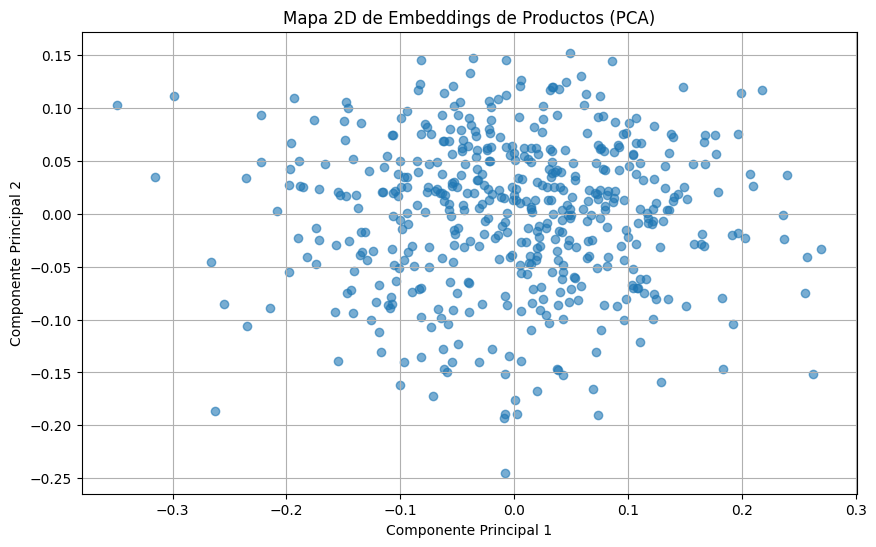

In [3]:
# 🎨 Visualizar embeddings de productos con PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extraer pesos de embeddings de productos
product_embedding_layer = model.get_layer('embedding_1')  # puede variar, asegúrate de que sea la correcta
product_weights = product_embedding_layer.get_weights()[0]

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2)
product_pca = pca.fit_transform(product_weights)

plt.figure(figsize=(10, 6))
plt.scatter(product_pca[:, 0], product_pca[:, 1], alpha=0.6)
plt.title("Mapa 2D de Embeddings de Productos (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()


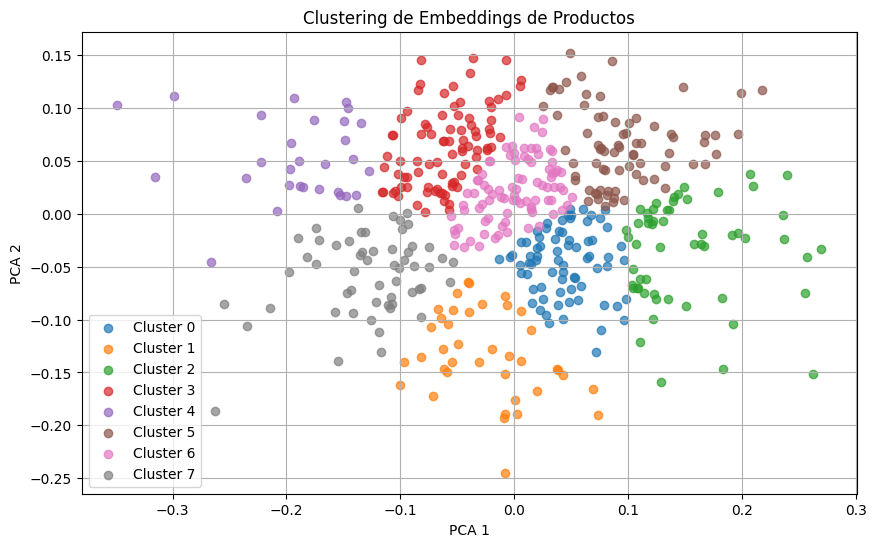

In [4]:
# 🔍 Clustering de productos en el espacio latente
from sklearn.cluster import KMeans

num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(product_pca)

plt.figure(figsize=(10, 6))
for c in range(num_clusters):
    idx = clusters == c
    plt.scatter(product_pca[idx, 0], product_pca[idx, 1], label=f'Cluster {c}', alpha=0.7)

plt.title("Clustering de Embeddings de Productos")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# 📊 Precision@K y Recall@K
def precision_recall_at_k(model, user_ids, true_df, K=10):
    precision_list = []
    recall_list = []

    for user_id in user_ids:
        # Productos comprados por el usuario
        true_products = set(true_df[true_df['user_id'] == user_id]['product_id'].values)
        if not true_products:
            continue

        # Todos los productos posibles
        all_products = np.arange(NUM_PRODUCTS)
        user_array = np.full_like(all_products, user_id)
        scores = model.predict([user_array, all_products], verbose=0).flatten()
        top_k_products = all_products[np.argsort(scores)[-K:][::-1]]

        hits = len(set(top_k_products) & true_products)
        precision = hits / K
        recall = hits / len(true_products)

        precision_list.append(precision)
        recall_list.append(recall)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    return avg_precision, avg_recall

# Evaluar en usuarios de test (solo los que tenían interacciones positivas)
user_subset = X_test[y_test == 1]['user_id'].unique()[:100]
precision, recall = precision_recall_at_k(model, user_subset, positives, K=10)

print(f"📌 Precision@10: {precision:.4f}")
print(f"📌 Recall@10: {recall:.4f}")


📌 Precision@10: 0.0250
📌 Recall@10: 0.0211
